In [1]:
from image_adjust import random_blur, systematic_blur, object_blur, non_semantic_transform, load_det_model
from bot_interface import prompt_InstructBlip
from response_compare import uncertainty_score
from transformers import InstructBlipForConditionalGeneration, InstructBlipProcessor
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import torch
import json
import warnings
warnings.filterwarnings("ignore")

/home/fieldaj1/.local/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
2025-02-17 10:36:41.140174: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 10:36:41.210739: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 10:36:44.290628: W tensorflow/compiler/t

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on", device)

Running on cuda


In [3]:
torch.cuda.set_device(1)


model_name = "Salesforce/instructblip-flan-t5-xl"
model = InstructBlipForConditionalGeneration.from_pretrained(model_name).to(device)
processor = InstructBlipProcessor.from_pretrained(model_name)

det_model = load_det_model()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Image Preparation

In [4]:
def find_json_obj(json_file, img_path):
    img = img_path.split("/")[-1]

    with open(json_file, 'r') as f:
        data = json.load(f)

    for obj in data:
        if obj.get("image") == img:
            return obj

    return None

In [5]:
ans_diff_reasons = ["low quality image", 
                    "unanswerable", 
                    "invalid", 
                    "difficult", 
                    "ambiguous", 
                    "subjective", 
                    "synonyms", 
                    "granular", 
                    "spam"]

Question: What is the tool in the middle used for?


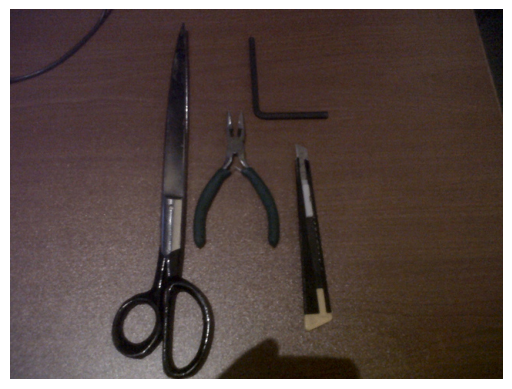

In [6]:
json_file = '/home/fieldaj1/thesis/data/VQA2.0/VQA_ans_diff_train.json'

img_path = '/home/fieldaj1/thesis/data/VQA2.0/img/COCO_train2014_000000001084.jpg'
img = cv2.imread(img_path)
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

qip = find_json_obj(json_file, img_path)
prompt = qip.get("question")
ans_diff_labels = qip.get("ans_diff_labels")

print("Question:", prompt)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [7]:
def write_images(imgs, path_name, suffix):
    paths = []
    for i, img in enumerate(imgs):
        path = f"{path_name}{i}{suffix}"
        cv2.imwrite(path, img)
        paths.append(path)

    return paths

In [16]:
num_perturbations = 8

non_sems = non_semantic_transform(img)
non_sem_paths = write_images(non_sems, "../data/out/nsem", ".jpg")

systematics = systematic_blur(img)
systematics_perturbed = [non_semantic_transform(s, n=num_perturbations) for s in systematics]
systematic_paths = [write_images(imgs, f"../data/out/rand-{j}-", ".jpg") for j, imgs in enumerate(systematics_perturbed)]

objects = object_blur(img, det_model)
objects_perturbed = [non_semantic_transform(o, n=num_perturbations) for o in objects]
object_paths = [write_images(imgs, f"../data/out/rand-{j}-", ".jpg") for j, imgs in enumerate(objects_perturbed)]

In [17]:
def pic_grid(imgs):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for ax, img in zip(axes.flat, imgs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')
    sns.despine(left=True, bottom=True)
    plt.show()

Neutral transforms


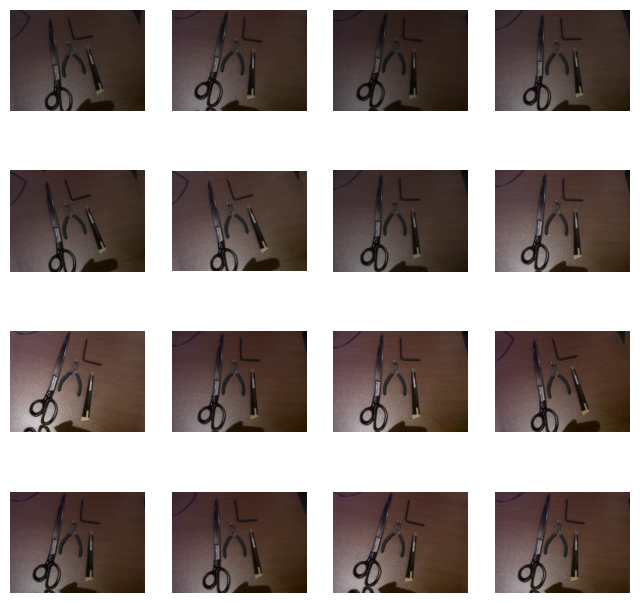

Systematic blur


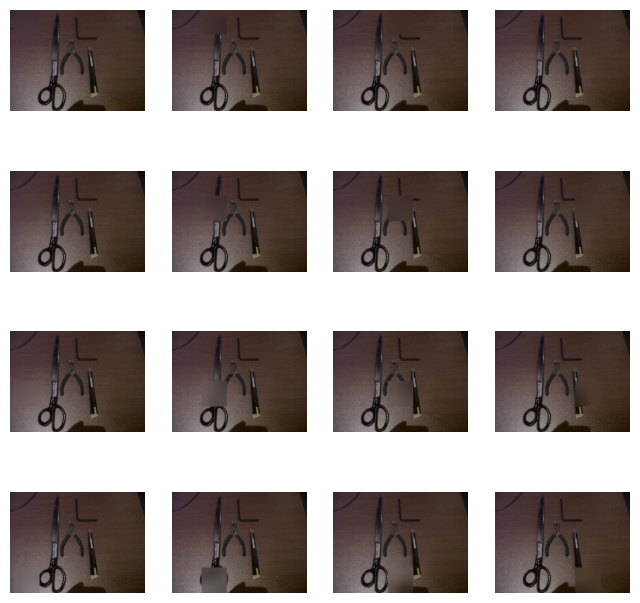

Object blur


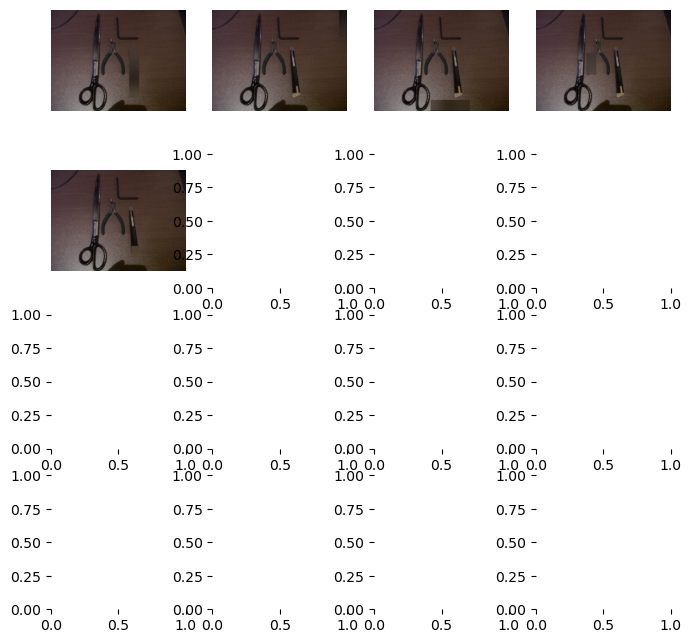

In [18]:
print("Neutral transforms"); pic_grid(non_sems) 
print("Systematic blur"); pic_grid(systematics)
print("Object blur"); pic_grid(objects) 

# Prompting

In [19]:
neutral_responses = prompt_InstructBlip(non_sem_paths, len(non_sem_paths) * [prompt], processor, model)
print('neutrals done')
systematic_responses = [prompt_InstructBlip(imgs, len(imgs) * [prompt], processor, model) for imgs in systematic_paths]
print('systematics done')
object_responses = [prompt_InstructBlip(imgs, len(imgs) * [prompt], processor, model) for imgs in object_paths]
print('objects done')

neutrals done
systematics done
objects done


# Analysis

In [20]:
neutral_score = uncertainty_score(neutral_responses)
systematic_scores = [uncertainty_score(s) for s in systematic_responses]
object_scores = [uncertainty_score(o) for o in object_responses]

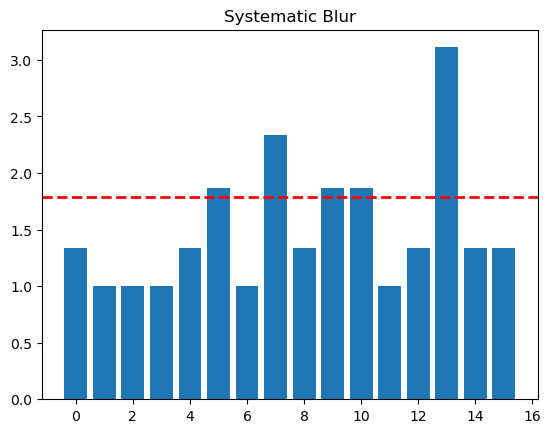

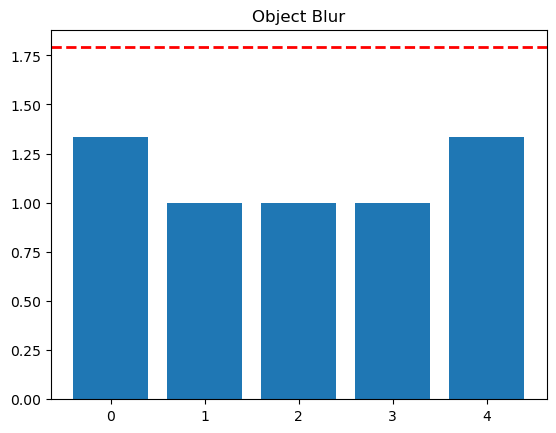

In [21]:
plt.bar(range(len(systematic_scores)), systematic_scores)
plt.axhline(y=neutral_score, color='red', linestyle='--', linewidth=2)
plt.title('Systematic Blur')
plt.show()

plt.bar(range(len(object_scores)), object_scores)
plt.axhline(y=neutral_score, color='red', linestyle='--', linewidth=2)
plt.title('Object Blur')
plt.show()

In [22]:
print(neutral_responses)

['cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'pliers', 'cutting', 'pliers', 'chopping', 'slicing', 'cutting', 'cutting', 'cutting', 'cutting']


In [23]:
print(systematic_responses)

[['pliers', 'pliers', 'pliers', 'pliers', 'cutting', 'pliers', 'pliers', 'pliers'], ['cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting'], ['cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting'], ['cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting'], ['cutting', 'cutting', 'cutting', 'pliers', 'cutting', 'cutting', 'cutting', 'cutting'], ['cutting', 'cutting', 'cutting', 'cutting', 'pliers', 'cutting', 'slicing', 'cutting'], ['cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting'], ['pliers', 'pliers', 'pliers', 'cutting', 'cutting', 'cutting', 'cutting', 'pliers'], ['cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'cutting', 'chopping', 'cutting'], ['cutting', 'cutting', 'cutting', 'chopping', 'cutting', 'cutting', 'slicing', 'cutting'], ['cutting', 'cutting', 'slicing', 'pliers', 'cutting', 'cutting', 'cutting', 'cutting'], ['cutting', 'cutting'